In [18]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [4]:
# load in the data
input_texts = []
target_texts = []
for line in open('./data/poetry/robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue

    input_line = '<sos> ' + line
    target_line = line + ' <eos>'

    input_texts.append(input_line)
    target_texts.append(target_line)

In [5]:
input_texts[1]

'<sos> And sorry I could not travel both'

In [6]:
target_texts[1]

'And sorry I could not travel both <eos>'

In [8]:
all_lines = input_texts + target_texts

In [9]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [14]:
input_sequences[10]

[1, 5, 141, 13, 941, 942, 405]

In [10]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [15]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [16]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [19]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('./data/word2vec/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [20]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [21]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [22]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)


In [23]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

Building model...
Instructions for updating:
Colocations handled automatically by placer.


In [24]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Training model...
Train on 1148 samples, validate on 288 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 5.4040 - acc: 0.0539 - val_loss: 5.0778 - val_acc: 0.0208
Epoch 2/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 4.6400 - acc: 0.0419 - val_loss: 4.8308 - val_acc: 0.0833
Epoch 3/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 4.3855 - acc: 0.0833 - val_loss: 4.9296 - val_acc: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 4.3321 - acc: 0.0833 - val_loss: 4.9600 - val_acc: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 4.3008 - acc: 0.0833 - val_loss: 5.0099 - val_acc: 0.0833
Epoch 6/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 4.2881 - acc: 0.0833 - val_loss: 5.0337

Epoch 56/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.8616 - acc: 0.1900 - val_loss: 5.1734 - val_acc: 0.0929
Epoch 57/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.8421 - acc: 0.1924 - val_loss: 5.1796 - val_acc: 0.0932
Epoch 58/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.8230 - acc: 0.1932 - val_loss: 5.1914 - val_acc: 0.0923
Epoch 59/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.8046 - acc: 0.1959 - val_loss: 5.1966 - val_acc: 0.0938
Epoch 60/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.7863 - acc: 0.1989 - val_loss: 5.2052 - val_acc: 0.0926
Epoch 61/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.7686 - acc: 0.2015 - val_loss: 5.2128 - val_acc: 0.0932
Epoch 62/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.7498 - acc: 0.2046 - val_loss: 5.2191 - val_acc: 0.0946
Epoch 63/2000
1148/1148 [==

Epoch 115/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.1181 - acc: 0.2803 - val_loss: 5.6308 - val_acc: 0.0804
Epoch 116/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.1116 - acc: 0.2823 - val_loss: 5.6428 - val_acc: 0.0822
Epoch 117/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.1031 - acc: 0.2810 - val_loss: 5.6423 - val_acc: 0.0819
Epoch 118/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.0935 - acc: 0.2834 - val_loss: 5.6599 - val_acc: 0.0802
Epoch 119/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.0856 - acc: 0.2856 - val_loss: 5.6665 - val_acc: 0.0804
Epoch 120/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.0762 - acc: 0.2853 - val_loss: 5.6689 - val_acc: 0.0842
Epoch 121/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 2.0685 - acc: 0.2872 - val_loss: 5.6768 - val_acc: 0.0767
Epoch 122/2000
1148/

1148/1148 [==============================] - 2s 2ms/sample - loss: 1.5468 - acc: 0.3688 - val_loss: 6.3764 - val_acc: 0.0637
Epoch 232/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.5430 - acc: 0.3688 - val_loss: 6.3765 - val_acc: 0.0605
Epoch 233/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.5387 - acc: 0.3704 - val_loss: 6.3805 - val_acc: 0.0593
Epoch 234/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.5385 - acc: 0.3688 - val_loss: 6.3919 - val_acc: 0.0613
Epoch 235/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.5362 - acc: 0.3693 - val_loss: 6.4064 - val_acc: 0.0613
Epoch 236/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.5337 - acc: 0.3699 - val_loss: 6.4020 - val_acc: 0.0616
Epoch 237/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.5302 - acc: 0.3699 - val_loss: 6.4109 - val_acc: 0.0599
Epoch 238/2000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 1.2956 - acc: 0.4151 - val_loss: 6.9330 - val_acc: 0.0498
Epoch 348/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.2930 - acc: 0.4168 - val_loss: 6.9215 - val_acc: 0.0558
Epoch 349/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.2920 - acc: 0.4149 - val_loss: 6.9560 - val_acc: 0.0480
Epoch 350/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.2922 - acc: 0.4146 - val_loss: 6.9319 - val_acc: 0.0530
Epoch 351/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.2926 - acc: 0.4162 - val_loss: 6.9449 - val_acc: 0.0518
Epoch 352/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.2937 - acc: 0.4159 - val_loss: 6.9652 - val_acc: 0.0515
Epoch 353/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.2925 - acc: 0.4164 - val_loss: 6.9512 - val_acc: 0.0503
Epoch 354/2000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 1.1417 - acc: 0.4466 - val_loss: 7.3131 - val_acc: 0.0509
Epoch 464/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.1433 - acc: 0.4462 - val_loss: 7.3516 - val_acc: 0.0503
Epoch 465/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.1440 - acc: 0.4468 - val_loss: 7.3157 - val_acc: 0.0506
Epoch 466/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.1414 - acc: 0.4472 - val_loss: 7.3485 - val_acc: 0.0515
Epoch 467/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.1397 - acc: 0.4468 - val_loss: 7.3506 - val_acc: 0.0498
Epoch 468/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.1369 - acc: 0.4483 - val_loss: 7.3364 - val_acc: 0.0501
Epoch 469/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.1348 - acc: 0.4495 - val_loss: 7.3389 - val_acc: 0.0503
Epoch 470/2000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 1.0486 - acc: 0.4670 - val_loss: 7.5762 - val_acc: 0.0480
Epoch 580/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.0641 - acc: 0.4624 - val_loss: 7.5786 - val_acc: 0.0492
Epoch 581/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.0656 - acc: 0.4645 - val_loss: 7.6070 - val_acc: 0.0448
Epoch 582/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.0567 - acc: 0.4648 - val_loss: 7.6092 - val_acc: 0.0460
Epoch 583/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.0502 - acc: 0.4649 - val_loss: 7.6086 - val_acc: 0.0480
Epoch 584/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.0473 - acc: 0.4657 - val_loss: 7.5972 - val_acc: 0.0463
Epoch 585/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 1.0555 - acc: 0.4662 - val_loss: 7.6238 - val_acc: 0.0451
Epoch 586/2000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9638 - acc: 0.4882 - val_loss: 7.8400 - val_acc: 0.0414
Epoch 696/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9634 - acc: 0.4864 - val_loss: 7.8253 - val_acc: 0.0405
Epoch 697/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9640 - acc: 0.4880 - val_loss: 7.8405 - val_acc: 0.0411
Epoch 698/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9626 - acc: 0.4871 - val_loss: 7.8370 - val_acc: 0.0414
Epoch 699/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9634 - acc: 0.4879 - val_loss: 7.8416 - val_acc: 0.0402
Epoch 700/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9615 - acc: 0.4883 - val_loss: 7.8393 - val_acc: 0.0396
Epoch 701/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9624 - acc: 0.4892 - val_loss: 7.8351 - val_acc: 0.0422
Epoch 702/2000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9228 - acc: 0.4951 - val_loss: 7.9667 - val_acc: 0.0422
Epoch 812/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9224 - acc: 0.4964 - val_loss: 7.9427 - val_acc: 0.0428
Epoch 813/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9216 - acc: 0.4956 - val_loss: 7.9760 - val_acc: 0.0425
Epoch 814/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9279 - acc: 0.4945 - val_loss: 7.9556 - val_acc: 0.0437
Epoch 815/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9318 - acc: 0.4933 - val_loss: 7.9541 - val_acc: 0.0431
Epoch 816/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9330 - acc: 0.4932 - val_loss: 7.9570 - val_acc: 0.0448
Epoch 817/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.9329 - acc: 0.4924 - val_loss: 7.9536 - val_acc: 0.0446
Epoch 818/2000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8850 - acc: 0.5025 - val_loss: 8.1688 - val_acc: 0.0396
Epoch 928/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8889 - acc: 0.5031 - val_loss: 8.1573 - val_acc: 0.0399
Epoch 929/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8858 - acc: 0.5046 - val_loss: 8.1629 - val_acc: 0.0405
Epoch 930/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8842 - acc: 0.5031 - val_loss: 8.1757 - val_acc: 0.0394
Epoch 931/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8841 - acc: 0.5041 - val_loss: 8.1556 - val_acc: 0.0402
Epoch 932/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8878 - acc: 0.5033 - val_loss: 8.1728 - val_acc: 0.0385
Epoch 933/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8892 - acc: 0.5028 - val_loss: 8.1643 - val_acc: 0.0420
Epoch 934/2000
1148/1148 [=========

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8517 - acc: 0.5128 - val_loss: 8.2255 - val_acc: 0.0440
Epoch 1044/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8511 - acc: 0.5126 - val_loss: 8.2047 - val_acc: 0.0425
Epoch 1045/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8559 - acc: 0.5099 - val_loss: 8.2354 - val_acc: 0.0417
Epoch 1046/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8530 - acc: 0.5114 - val_loss: 8.2039 - val_acc: 0.0422
Epoch 1047/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8574 - acc: 0.5113 - val_loss: 8.2382 - val_acc: 0.0405
Epoch 1048/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8567 - acc: 0.5095 - val_loss: 8.2172 - val_acc: 0.0425
Epoch 1049/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8565 - acc: 0.5114 - val_loss: 8.2358 - val_acc: 0.0402
Epoch 1050/2000
1148/1148 [==

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8365 - acc: 0.5151 - val_loss: 8.3214 - val_acc: 0.0434
Epoch 1160/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8368 - acc: 0.5164 - val_loss: 8.2794 - val_acc: 0.0431
Epoch 1161/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8425 - acc: 0.5138 - val_loss: 8.3353 - val_acc: 0.0425
Epoch 1162/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8512 - acc: 0.5123 - val_loss: 8.2504 - val_acc: 0.0451
Epoch 1163/2000
1148/1148 [==============================] - 2s 1ms/sample - loss: 0.8644 - acc: 0.5062 - val_loss: 8.3295 - val_acc: 0.0434
Epoch 1164/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8581 - acc: 0.5084 - val_loss: 8.2865 - val_acc: 0.0440
Epoch 1165/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8526 - acc: 0.5103 - val_loss: 8.3117 - val_acc: 0.0428
Epoch 1166/2000
1148/1148 [==

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8182 - acc: 0.5194 - val_loss: 8.3886 - val_acc: 0.0431
Epoch 1276/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8193 - acc: 0.5200 - val_loss: 8.4034 - val_acc: 0.0437
Epoch 1277/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8194 - acc: 0.5195 - val_loss: 8.3955 - val_acc: 0.0437
Epoch 1278/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8168 - acc: 0.5195 - val_loss: 8.4063 - val_acc: 0.0417
Epoch 1279/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8177 - acc: 0.5200 - val_loss: 8.3728 - val_acc: 0.0434
Epoch 1280/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8183 - acc: 0.5192 - val_loss: 8.3870 - val_acc: 0.0428
Epoch 1281/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8167 - acc: 0.5203 - val_loss: 8.4007 - val_acc: 0.0434
Epoch 1282/2000
1148/1148 [==

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8023 - acc: 0.5218 - val_loss: 8.4449 - val_acc: 0.0431
Epoch 1392/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8002 - acc: 0.5234 - val_loss: 8.4495 - val_acc: 0.0411
Epoch 1393/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8067 - acc: 0.5213 - val_loss: 8.4613 - val_acc: 0.0399
Epoch 1394/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8072 - acc: 0.5222 - val_loss: 8.4386 - val_acc: 0.0408
Epoch 1395/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8068 - acc: 0.5209 - val_loss: 8.4342 - val_acc: 0.0417
Epoch 1396/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8012 - acc: 0.5232 - val_loss: 8.4547 - val_acc: 0.0411
Epoch 1397/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8004 - acc: 0.5226 - val_loss: 8.4713 - val_acc: 0.0408
Epoch 1398/2000
1148/1148 [==

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8763 - acc: 0.5016 - val_loss: 8.5311 - val_acc: 0.0417
Epoch 1508/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8707 - acc: 0.5013 - val_loss: 8.5437 - val_acc: 0.0414
Epoch 1509/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8601 - acc: 0.5036 - val_loss: 8.5585 - val_acc: 0.0411
Epoch 1510/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8510 - acc: 0.5082 - val_loss: 8.5518 - val_acc: 0.0394
Epoch 1511/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8407 - acc: 0.5083 - val_loss: 8.5537 - val_acc: 0.0405
Epoch 1512/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8372 - acc: 0.5128 - val_loss: 8.5716 - val_acc: 0.0408
Epoch 1513/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8250 - acc: 0.5137 - val_loss: 8.5596 - val_acc: 0.0422
Epoch 1514/2000
1148/1148 [==

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8065 - acc: 0.5208 - val_loss: 8.5640 - val_acc: 0.0402
Epoch 1624/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8053 - acc: 0.5212 - val_loss: 8.5714 - val_acc: 0.0420
Epoch 1625/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8126 - acc: 0.5190 - val_loss: 8.5794 - val_acc: 0.0405
Epoch 1626/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8060 - acc: 0.5189 - val_loss: 8.5736 - val_acc: 0.0434
Epoch 1627/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8142 - acc: 0.5195 - val_loss: 8.5695 - val_acc: 0.0414
Epoch 1628/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8103 - acc: 0.5194 - val_loss: 8.5520 - val_acc: 0.0425
Epoch 1629/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8029 - acc: 0.5206 - val_loss: 8.5452 - val_acc: 0.0408
Epoch 1630/2000
1148/1148 [==

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7860 - acc: 0.5236 - val_loss: 8.6138 - val_acc: 0.0420
Epoch 1740/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7853 - acc: 0.5269 - val_loss: 8.6324 - val_acc: 0.0399
Epoch 1741/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7948 - acc: 0.5242 - val_loss: 8.6444 - val_acc: 0.0414
Epoch 1742/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8356 - acc: 0.5127 - val_loss: 8.5929 - val_acc: 0.0443
Epoch 1743/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8552 - acc: 0.5060 - val_loss: 8.5852 - val_acc: 0.0463
Epoch 1744/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8849 - acc: 0.4994 - val_loss: 8.6004 - val_acc: 0.0431
Epoch 1745/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.8932 - acc: 0.4962 - val_loss: 8.5803 - val_acc: 0.0434
Epoch 1746/2000
1148/1148 [==

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7620 - acc: 0.5314 - val_loss: 8.6133 - val_acc: 0.0434
Epoch 1856/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7649 - acc: 0.5320 - val_loss: 8.6302 - val_acc: 0.0417
Epoch 1857/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7667 - acc: 0.5301 - val_loss: 8.6241 - val_acc: 0.0431
Epoch 1858/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7751 - acc: 0.5270 - val_loss: 8.6260 - val_acc: 0.0420
Epoch 1859/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7769 - acc: 0.5282 - val_loss: 8.6300 - val_acc: 0.0420
Epoch 1860/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7810 - acc: 0.5271 - val_loss: 8.6338 - val_acc: 0.0405
Epoch 1861/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7876 - acc: 0.5261 - val_loss: 8.6299 - val_acc: 0.0425
Epoch 1862/2000
1148/1148 [==

1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7846 - acc: 0.5239 - val_loss: 8.7355 - val_acc: 0.0402
Epoch 1972/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7876 - acc: 0.5230 - val_loss: 8.7233 - val_acc: 0.0405
Epoch 1973/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7832 - acc: 0.5245 - val_loss: 8.7226 - val_acc: 0.0391
Epoch 1974/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7809 - acc: 0.5266 - val_loss: 8.7136 - val_acc: 0.0411
Epoch 1975/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7800 - acc: 0.5265 - val_loss: 8.7278 - val_acc: 0.0414
Epoch 1976/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7775 - acc: 0.5270 - val_loss: 8.7141 - val_acc: 0.0411
Epoch 1977/2000
1148/1148 [==============================] - 2s 2ms/sample - loss: 0.7778 - acc: 0.5280 - val_loss: 8.7079 - val_acc: 0.0411
Epoch 1978/2000
1148/1148 [==

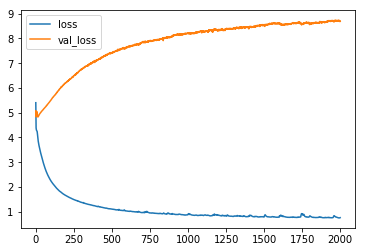

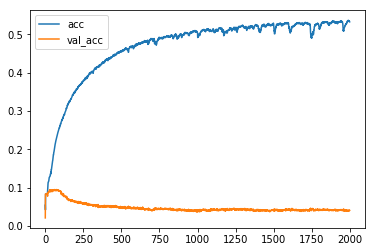

In [25]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [26]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [27]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [ ]:
def sample_line():
    # initial inputs
    np_input = np.array([[ word2idx['<sos>'] ]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))

    # so we know when to quit
    eos = word2idx['<eos>']

    # store the output here
    output_sentence = []

    for _ in range(max_sequence_length):
        o, h, c = sampling_model.predict([np_input, h, c])

        # print("o.shape:", o.shape, o[0,0,:10])
        # idx = np.argmax(o[0,0])
        probs = o[0,0]
        if np.argmax(probs) == 0:
            print("wtf")
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break

        # accuulate output
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

        # make the next input into model
        np_input[0,0] = idx

    return ' '.join(output_sentence)

In [ ]:
# generate a 4 line poem
while True:
    for _ in range(4):
        print(sample_line())

    ans = input("---generate another? [Y/n]---")
    if ans and ans[0].lower().startswith('n'):
        break

they spoke of having myself in the stars
no bird was singing in it up
rather than tip a table for you, let me
we made a stark old digger,
---generate another? [Y/n]---y
the same as if you're like this pride of ancestry, we yankees?
'to shut you up i'll tell you what i'll do:
proclaimed the time was neither wrong nor right.
the night the bones came up the cellar-stairs


In [ ]:
model.save('./models/poetry_v1.h5')